In [34]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

In [35]:
CFG = {
    'img_size': 260,
    'bs': 64,
    'seed': 0,
    'device': 'cuda:0',
    'model' : '/mobilenet_v3_large',
    'model_dir': '/KD_pet_resnet152_mobilenet_v3_large_202305202212',
    'num_workers': 8
}


In [36]:
classes16 = ["10Kwalk","battery",'box','else','bottle','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'dishes']

classes19 = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']
dishes_class = ['wrap','leftover','green dish']
box_class = ["box","untapedBox"]
pet_class = ["unlabeled","labeled"]
bottle_class = ["toothcup","tumbler"]


In [37]:
# TEST DATASET DATAFRAME
label_list = pet_class
test_path = '../Data/carbon_reduction_data/new_test_05m/'
test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: unlabeled 1651
label: labeled 0
Test_Images:  1651
Test_Images_labels: 1651


##### label list for labelencoding

In [38]:
label_list

['unlabeled', 'labeled']

In [39]:
## Pandas 데이터프레임 만들기
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df

In [40]:
le = preprocessing.LabelEncoder()
le.fit_transform(label_list)
test['label'] = le.transform(test['label'].values)
test

,image_id,dir,label
0,image_cropper_16820539422621682053947919.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1
1,image_cropper_16825111301561682511139447.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1
2,image_cropper_16823394638241682339491333.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1
3,image_cropper_16824221667001682422183026.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1
4,image_cropper_3C627725-54B7-45F4-8589-BB179332...,../Data/carbon_reduction_data/new_test_05m/unl...,1
...,...,...,...
1646,image_cropper_16828947237381682894730174.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1
1647,image_cropper_CC59A326-B29C-4EC5-B4AB-DAA2B78C...,../Data/carbon_reduction_data/new_test_05m/unl...,1
1648,image_cropper_E3BC5895-A463-40ED-9B77-F85B4F28...,../Data/carbon_reduction_data/new_test_05m/unl...,1
1649,image_cropper_16817710147081681771023022.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,1


In [41]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [42]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

class CustomDataset(Dataset):
    def __init__(
        self, df, data_root, transform=transform_test):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.data_root = data_root
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
          
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        if self.transform:
            img = self.transform(image=img)['image']
            
        return img 


In [43]:
# LOAD PRE-TRAINED MODEL
class Model(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Model, self).__init__()
        self.backbone = models.mobilenet_v3_large(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.classifier[-1] = nn.Linear(self.backbone.classifier[-1].in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [44]:
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [45]:
# RUN INFERENCE
model = Model(CFG['model'], len(label_list), pretrained=True)
load_model = './models/' + CFG['model_dir'] + CFG['model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:59<00:00,  2.28s/it]


In [46]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,image_cropper_16820539422621682053947919.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
1,image_cropper_16825111301561682511139447.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
2,image_cropper_16823394638241682339491333.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
3,image_cropper_16824221667001682422183026.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
4,image_cropper_3C627725-54B7-45F4-8589-BB179332...,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
...,...,...,...,...
1646,image_cropper_16828947237381682894730174.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
1647,image_cropper_CC59A326-B29C-4EC5-B4AB-DAA2B78C...,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
1648,image_cropper_E3BC5895-A463-40ED-9B77-F85B4F28...,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled
1649,image_cropper_16817710147081681771023022.jpg,../Data/carbon_reduction_data/new_test_05m/unl...,unlabeled,unlabeled


accuracy: 0.9788
f1_score: 0.4946


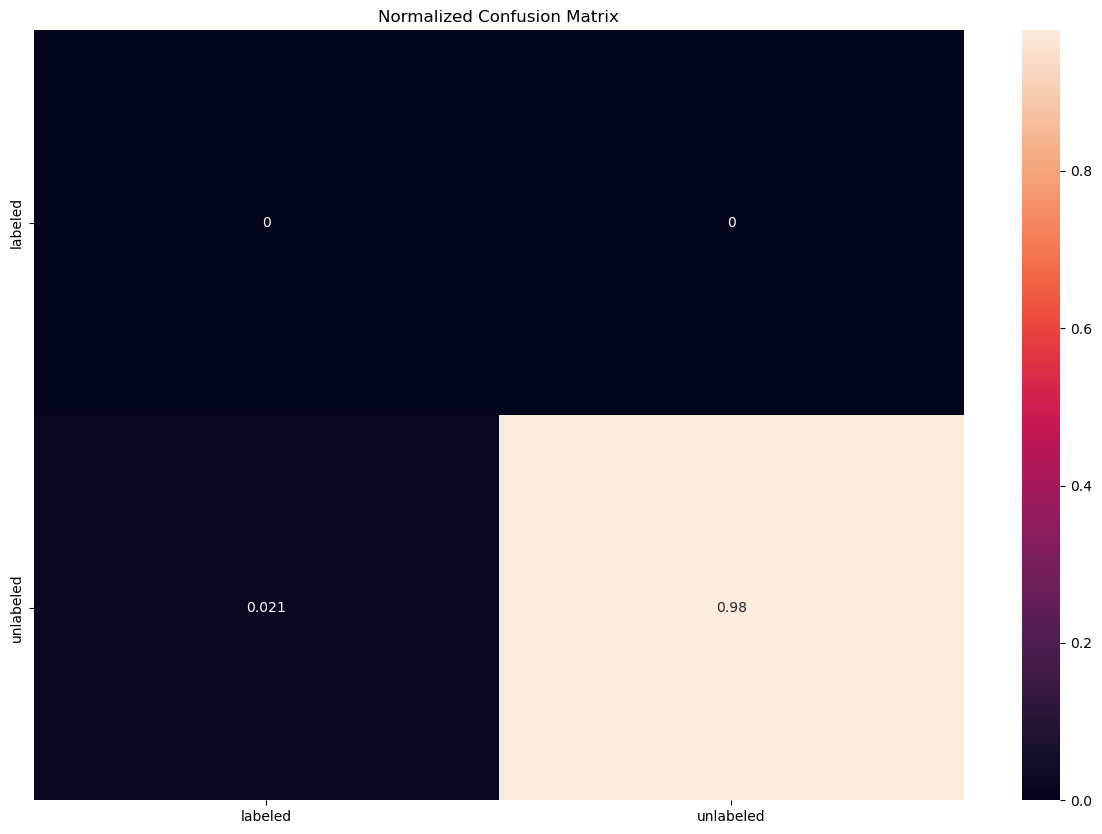

In [47]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(label_list)), 
            yticklabels = sorted(set(label_list)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')